In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json

pd.options.display.max_columns = None

import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation

%matplotlib inline
%reload_ext autoreload
%autoreload 2
sns.set_palette("muted")
#sns.set(color_codes=True)

/var/folders/sf/9c9rzpyx3433zsvwfyt4fccw0000gn/T/ipykernel_23035/3310040328.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Google Sheets Data

book_log_2019 = pd.read_csv('data/book_log_2019.tsv', sep='\t', header=0)
book_log_2020 = pd.read_csv('data/book_log_2020.tsv', sep='\t', header=0)
book_log_2021 = pd.read_csv('data/book_log_2021.tsv', sep='\t', header=0)
book_log_2022 = pd.read_csv('data/book_log_2022.tsv', sep='\t', header=0)
book_log_2023 = pd.read_csv('data/book_log_2023.tsv', sep='\t', header=0)

book_log_2019['Year Read'] = '2019'
book_log_2020['Year Read'] = '2020'
book_log_2021['Year Read'] = '2021'
book_log_2022['Year Read'] = '2022'
book_log_2023['Year Read'] = '2023'

book_log_df = pd.concat([book_log_2019, book_log_2020, book_log_2021, book_log_2022, book_log_2023], axis=0, ignore_index=True)
book_log_df['Rating'] = book_log_df['Rating'].apply(lambda x: float(x.split('/')[0]))
book_log_df['Re-Read?'] = book_log_df['Re-Read?'].map({'Yes': True, 'No': False})
book_log_df['Book Club?'] = book_log_df['Book Club?'].map({'Yes': True, 'No': False})
book_log_df['Technical?'] = book_log_df['Technical?'].map({'Yes': True, 'No': False})

book_log_df['Start Date'] = book_log_df['Start Date'] + '/' + book_log_df['Year Read']
book_log_df['Start Date'] = pd.to_datetime(book_log_df['Start Date'], format='%d/%m/%Y')
book_log_df['End Date'] = book_log_df['End Date'] + '/' + book_log_df['Year Read']
book_log_df['End Date'] = pd.to_datetime(book_log_df['End Date'], format='%d/%m/%Y')


book_log_df['Start Month'] = book_log_df['Start Date'].dt.strftime('%m-%Y')
book_log_df['End Month'] = book_log_df['End Date'].dt.strftime('%m-%Y')

book_log_df['Num Days Reading'] = (book_log_df['End Date'] - book_log_df['Start Date']).dt.days + 1

book_log_df['Year Read'] = book_log_df['Year Read'].astype("int64")

book_log_df['Display Genre'] = book_log_df['Display Genre'].astype("category")
book_log_df['Type'] = book_log_df['Type'].astype("category")
book_log_df['Format'] = book_log_df['Format'].astype("category")

book_log_df['Format'] = book_log_df['Format'].astype("category")
book_log_df['Format'] = book_log_df['Format'].astype("category")

# Convert the '-' placeholder value to Nan and cast these columns to float so we use mean/sum etc.
book_log_df[['Hours', 'Pages']] = book_log_df[['Hours', 'Pages']].replace('-', np.nan)
book_log_df['Hours'] = book_log_df['Hours'].astype("float64")
book_log_df['Pages'] = book_log_df['Pages'].astype("float64")

# Average pages/hours per day read/listened while this book was in progress
book_log_df['Pages Per Day'] = book_log_df.apply(lambda row: (row['Pages'] / row['Num Days Reading']), axis=1)
book_log_df['Hours Per Day'] = book_log_df.apply(lambda row: (row['Hours'] / row['Num Days Reading']), axis=1)

book_log_df.rename(columns={'Rating': 'My Rating'}, inplace=True)
book_log_df.rename(columns={'Title': 'Title GSheet'}, inplace=True)

# Drop some columns that I won't use in this analysis
book_log_df.drop(columns=['Genre(s)', 'Cover', 'Year Purchased', 'Tags'], inplace=True)

book_log_df.head(5)

,Title GSheet,Start Date,End Date,Author(s),Display Genre,Type,Format,Pages,Hours,My Rating,Re-Read?,Book Club?,Technical?,Goodreads,Year Read,Start Month,End Month,Num Days Reading,Pages Per Day,Hours Per Day
0,Prince of Fools,2019-01-01,2019-01-07,Mark Lawrence,Fantasy,Fiction,Physical,502.0,NaN,3.5,False,False,False,https://www.goodreads.com/book/show/25262299-p...,2019,01-2019,01-2019,7,71.714286,NaN
1,Designing Data-Intensive Applications,2019-01-04,2019-05-10,Martin Kleppmann,Technology,Non-Fiction,Physical,546.0,NaN,5.0,False,False,True,https://www.goodreads.com/book/show/23463279-d...,2019,01-2019,05-2019,127,4.299213,NaN
2,Scar Tissue,2019-01-09,2019-01-18,Anthony Kiedis,Biography,Non-Fiction,Physical,465.0,NaN,3.5,False,False,False,https://goodreads.com/book/show/4303.Scar_Tissue,2019,01-2019,01-2019,10,46.500000,NaN
3,The Gallic Wars,2019-01-19,2019-01-27,Julius Caesar,History,Non-Fiction,Physical,260.0,NaN,4.0,False,False,False,https://goodreads.com/book/show/37807.Caesar_s...,2019,01-2019,01-2019,9,28.888889,NaN
4,Fire and Fury,2019-01-28,2019-02-06,Michael Wolff,Politics,Non-Fiction,Physical,336.0,NaN,3.5,False,False,False,https://www.goodreads.com/book/show/36595101-f...,2019,01-2019,02-2019,10,33.600000,NaN


In [3]:
# Goodreads Ratings & Published Information
# This data was scraped from goodreads using Typescript/Puppeteer

# 'First published January 1, 2023' -> datetime.datetime(2023, 1, 1, 0, 0)
# 'First published April 20, 68' -> datetime.datetime(68, 4, 20, 0, 0)
# 'First published May 10, 329' -> datetime.datetime(329, 5, 10, 0, 0)

# BC years are presented with negative int, e.g. 376BC = -376
# So be careful when doing year based arithmetic
def parse_published_dt(published_str):
 is_bc = True if published_str.endswith(' BC') else False
 stripped = published_str.removeprefix('First published ').removesuffix(' BC')
 year = stripped.split(' ')[-1]
 padded_year = year.zfill(4)
    
 #return datetime.strptime(stripped[:-len(year)] + padded_year, "%B %d, %Y")
 return -int(padded_year) if is_bc else int(padded_year)

published_period_mapping = [
  ("Antiquity", 499), # 3000BC -> 499
  ("Post Classical", 1499), # 500 -> 1499 
  ("Early Modern", 1799), # 1500 -> 1799
  ("Late Modern", 1944), # 1800 -> 1944
  ("Contemporary (20th)", 1999), # 1945 -> 1999
  ("Contemporary (21st)", float('inf')) # 2000 -> Present
]

def get_published_period(year):
    for period, end_year in published_period_mapping:
        if year <= end_year:
            return period


def parse_ratings_data(row):
    # Rating
    rating_gr = float(row['rating'])
    
    # Titles
    title_gs = row['title'] # i.e. the title from the gsheet
    title_gr = row['scrapedTitle']
    split = title_gr.split(':')
    title = split[0].strip()
    subtitle = title if len(split) == 1 else split[1].strip()
    
    # Publish Year & Period
    year_published = parse_published_dt(row['publicationInfo'])  
    period_published = get_published_period(year_published)  

    # Num Ratings 
    num_ratings = int(row['ratingStats'].split(' ')[0].replace(',', ''))
    
    # Num Reviews 
    num_reviews = int(row['ratingStats'].split(' ')[-2].replace(',', ''))
    
    # Num Stars
    num_five_stars = int(row['fiveStarRatings'].split(' ')[0].replace(',', ''))
    num_four_stars = int(row['fourStarRatings'].split(' ')[0].replace(',', ''))
    num_three_stars = int(row['threeStarRatings'].split(' ')[0].replace(',', ''))
    num_two_stars = int(row['twoStarRatings'].split(' ')[0].replace(',', ''))
    num_one_stars = int(row['oneStarRatings'].split(' ')[0].replace(',', ''))

                                                  
    return {
        "Goodreads Rating": rating_gr,
        "Full Title": title_gr,
        "Title": title,
        "Subtitle": subtitle,
        "Year Published": year_published,
        "Period Published": period_published,
        "Num Reviews": num_reviews,
        "Num Ratings": num_ratings,
        "Num Five Stars": num_five_stars,
        "Num Four Stars": num_four_stars,
        "Num Three Stars": num_three_stars,
        "Num Two Stars": num_two_stars,
        "Num One Stars": num_one_stars
    }


ratings_2019_file = open('data/ratings_2019.json')
ratings_2019 = json.load(ratings_2019_file)

ratings_2020_file = open('data/ratings_2020.json')
ratings_2020 = json.load(ratings_2020_file)

ratings_2021_file = open('data/ratings_2021.json')
ratings_2021 = json.load(ratings_2021_file)

ratings_2022_file = open('data/ratings_2022.json')
ratings_2022 = json.load(ratings_2022_file)

ratings_2023_file = open('data/ratings_2023.json')
ratings_2023 = json.load(ratings_2023_file)

all_ratings = ratings_2019 + ratings_2020 + ratings_2021 + ratings_2022 + ratings_2023

parsed_ratings = [parse_ratings_data(row) for row in all_ratings]

ratings_df = pd.DataFrame(parsed_ratings)

ratings_df.head(5)

,Goodreads Rating,Full Title,Title,Subtitle,Year Published,Period Published,Num Reviews,Num Ratings,Num Five Stars,Num Four Stars,Num Three Stars,Num Two Stars,Num One Stars
0,4.06,Prince of Fools,Prince of Fools,Prince of Fools,2014,Contemporary (21st),2489,32412,11379,13581,5763,1274,415
1,4.71,Designing Data-Intensive Applications,Designing Data-Intensive Applications,Designing Data-Intensive Applications,2015,Contemporary (21st),746,8095,6216,1530,278,46,25
2,4.11,Scar Tissue,Scar Tissue,Scar Tissue,2004,Contemporary (21st),3843,88706,37629,30622,14859,3893,1703
3,4.11,Caesar's Commentaries: On the Gallic War & On ...,Caesar's Commentaries,On the Gallic War & On the Civil War,-51,Antiquity,67,959,373,372,168,39,7
4,3.44,Fire and Fury: Inside the Trump White House,Fire and Fury,Inside the Trump White House,2018,Contemporary (21st),9047,75668,12117,23996,27548,8873,3134


In [4]:
# Checking that only expected values are present, e.g. find duplicate values caused by whitespace
print(sorted(book_log_df['Type'].unique()))
print(sorted(book_log_df['Format'].unique()))
print(sorted(book_log_df['Display Genre'].unique()))
print(book_log_df['Re-Read?'].unique())
print(book_log_df['Book Club?'].unique())
print(book_log_df['Technical?'].unique())
print(book_log_df['My Rating'].unique())
print(ratings_df['Period Published'].unique())

['Fiction', 'Non-Fiction']
['Audible', 'Kindle', 'Physical']
['Biography', 'Business', 'Classics', 'Fantasy', 'History', 'Miscellaneous', 'Novel', 'Philosophy', 'Politics', 'Science', 'Science Fiction', 'Self-Improvement', 'Technical', 'Technology', 'True Crime']
[False  True]
[False  True]
[False  True]
[3.5 5.  4.  3.  2.5 4.5]
['Contemporary (21st)' 'Antiquity' 'Late Modern' 'Contemporary (20th)'
 'Early Modern']


In [5]:
# I used ChatGPT to retrieve the genders for my list of authors. It worked well

# Some books have multiple authors, and the source text file has the authors comma separated
# e.g. Abhijit Banerjee, Esther Duflo - Male, Female
# For the purposes of this data analysis, in cases where there are multiple authors I choose the majority gender.  
# In cases where it's a 50:50 split, I will choose female as the gender because there is such a big class imbalance 
#in the genders in this dataset. I think this tie-break rule only gets used in one or two examples, FWIW.
gender_data = []

with open('data/Author Genders.txt', 'r') as file:
    for line in file:
        processed_line = line.split(' - ')
        authors = processed_line[0].strip()
        num_authors = len(authors.split(','))

        genders = processed_line[1].strip()
        genders_split = [gender.strip() for gender in genders.split(',')]
        num_male = sum([1 if gender == 'Male' else 0 for gender in genders_split])
        num_female = sum([1 if gender == 'Female' else 0 for gender in genders_split])
        
        display_gender = 'Male' if num_male > num_female else 'Female' 

        gender_data.append({'Author(s)': authors, 'Gender(s)':genders, 'Num Authors': num_authors, 'Author Gender': display_gender})

genders_df = pd.DataFrame(gender_data)
# Remove any duplicate authors, this will make the join logic 1:1 when joining this to the book_log_df
genders_df = genders_df.drop_duplicates()
genders_df.head(5)

,Author(s),Gender(s),Num Authors,Author Gender
0,Mark Lawrence,Male,1,Male
1,Martin Kleppmann,Male,1,Male
2,Anthony Kiedis,Male,1,Male
3,Julius Caesar,Male,1,Male
4,Michael Wolff,Male,1,Male


In [33]:
final_df = book_log_df.join(ratings_df, how='left')
final_df = pd.merge(final_df, genders_df, on='Author(s)', how='left')
# Rating Delta = difference between my rating and goodreads rating. Negative means I rated lower than goodreads.
final_df['Rating Delta'] = final_df.apply(lambda row: row['My Rating'] - row['Goodreads Rating'], axis=1)
final_df['Rating Delta Absolute'] = final_df.apply(lambda row: abs(row['My Rating'] - row['Goodreads Rating']), axis=1)
# Read On Release = true if read within ~1 year of release
final_df['Read On Release?'] = final_df.apply(lambda row: True if (row['Year Read'] - row['Year Published']) in [0,1] else False, axis=1)

# Percentage of the Book ratings that were one or five star
final_df['1-Star Rating Percentage'] = final_df.apply(lambda row: (row['Num One Stars'] / row['Num Ratings'])*100, axis=1)
final_df['5-Star Rating Percentage'] = final_df.apply(lambda row: (row['Num Five Stars'] / row['Num Ratings'])*100, axis=1)

# Define rating bins, 2.5 to 5, in 0.25 bins
bins = np.arange(2.5, 5.25, 0.25)
# Bucket the values
final_df['Goodreads Rating Binned'] = pd.cut(final_df['Goodreads Rating'], bins=bins, include_lowest=True)

# Save to local file 
final_df.to_csv('data/final_df.tsv', sep='\t', index=False)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Title GSheet              268 non-null    object        
 1   Start Date                268 non-null    datetime64[ns]
 2   End Date                  268 non-null    datetime64[ns]
 3   Author(s)                 268 non-null    object        
 4   Display Genre             268 non-null    category      
 5   Type                      268 non-null    category      
 6   Format                    268 non-null    category      
 7   Pages                     200 non-null    float64       
 8   Hours                     68 non-null     float64       
 9   My Rating                 268 non-null    float64       
 10  Re-Read?                  268 non-null    bool          
 11  Book Club?                268 non-null    bool          
 12  Technical?            

In [7]:
# Show a subset of the columns
final_df[['Title', 'Start Date', 'End Date', 'My Rating', 'Year Published', 'Pages', 'Hours']].tail(5)

,Title,Start Date,End Date,My Rating,Year Published,Pages,Hours
263,The Hitchhiker's Guide to the Galaxy,2023-11-11,2023-11-22,4.5,1979,NaN,5.0
264,Pax,2023-11-20,2023-11-30,4.0,2023,NaN,15.0
265,Ready Player One,2023-11-26,2023-11-28,4.0,2011,374.0,NaN
266,The Hobbit,2023-11-30,2023-12-06,4.5,1937,NaN,10.5
267,1984,2023-12-02,2023-12-28,4.5,1949,368.0,NaN


In [8]:
# Calculate the average pages read and hours listened for every date 2019-2023. 
# Note these are averaged figures, exact hours/pages will have varied greatly on any given day
from collections import defaultdict 

avg_pages_per_date = defaultdict(float)
avg_hours_per_date = defaultdict(float)

# Iterate through each row and access values of 'Name' and 'Age'
for index, row in final_df.iterrows():
    pages_per_day = 0
    hours_per_day = 0
    # Listening
    if row['Format'] == 'Audible':
        hours_per_day = row['Hours'] / row['Num Days Reading']
    # Reading
    else:
        pages_per_day = row['Pages'] / row['Num Days Reading']

    start_date = row['Start Date']
    end_date = row['End Date']
    current_date = start_date
    while current_date <= end_date:
        date_key = current_date.strftime('%Y-%m-%d')
        avg_pages_per_date[date_key] += pages_per_day
        avg_hours_per_date[date_key] += hours_per_day
        current_date += timedelta(days=1)


avg_pages_per_date = sorted(list(avg_pages_per_date.items()), key=lambda x: datetime.strptime(x[0], "%Y-%m-%d"))
avg_hours_per_date = sorted(list(avg_hours_per_date.items()), key=lambda x: datetime.strptime(x[0], "%Y-%m-%d"))


# Calculating the pages read/hours listened for each month 
hours_monthly = defaultdict(float)
pages_monthly = defaultdict(float)

for date_str, value in avg_hours_per_date:
    # Convert string to datetime object
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    # Create a month/year key
    key = (dt.month, dt.year)
    # Sum values for each month/year
    hours_monthly[key] += value

for date_str, value in avg_pages_per_date:
    # Convert string to datetime object
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    # Create a month/year key
    key = (dt.month, dt.year)
    # Sum values for each month/year
    pages_monthly[key] += value

# The tuple format is ((month, year), summed_value)
avg_hours_per_month = sorted(list(hours_monthly.items()), key=lambda x: (x[0][1], x[0][0])) # Sort by year then month
avg_pages_per_month = sorted(list(pages_monthly.items()), key=lambda x: (x[0][1], x[0][0])) # Sort by year then month

months_sorted_by_pages_read = sorted(avg_pages_per_month, key=lambda x: x[1], reverse=True)
months_sorted_by_hours_listened = sorted(avg_hours_per_month, key=lambda x: x[1], reverse=True)

# TODO: Calculate the mean and standard deviation?
print(months_sorted_by_pages_read[0:5])

[((10, 2023), 2393.7656641604012), ((6, 2020), 2196.0769230769233), ((10, 2019), 2165.1269841269836), ((8, 2021), 2003.422498030925), ((7, 2023), 1851.6315789473683)]


# Summary Statistics

In [9]:
# Totals
num_all_books = len(final_df)
num_audiobooks = (final_df['Format']=='Audible').sum()
num_books = (final_df['Format']!='Audible').sum()

print(f"Total number of weeks for this 5-year time period : {5*52}")
print(f"Total number of books read/listened to across all formats: {num_all_books}")
print(f"Total number of audio books listened to: {num_audiobooks}")
print(f"Total number of books read: {num_books}")

total_hours_listened = final_df['Hours'].sum()
total_pages_read = final_df['Pages'].sum()

print(f"Total number of hours listened to: {total_hours_listened}")
print(f"Total number of pages read: {total_pages_read}")
print("")

# Averages
my_rating_average = final_df['My Rating'].mean()
goodreads_rating_average = final_df['Goodreads Rating'].mean()

print(f"My average rating was: {my_rating_average:.2f}")
print(f"Compared to the goodreads average of: {goodreads_rating_average:.2f}")
print(f"So I rated books: {goodreads_rating_average-my_rating_average:.2f} less on average than the goodreads rating")

book_length_pages_average = final_df['Pages'].mean()
audiobook_length_hours_average = final_df['Hours'].mean()
print(f"The average book length was: {book_length_pages_average:.2f} pages")
print(f"The average audiobook length was: {audiobook_length_hours_average:.2f} hours")

pages_read_per_day_average = final_df['Pages'].sum()/(5*365)
hours_read_per_day_average = final_df['Hours'].sum()/(5*365)
pages_read_per_week_average = final_df['Pages'].sum()/(5*52)
hours_read_per_week_average = final_df['Hours'].sum()/(5*52)
pages_read_per_month_average = final_df['Pages'].sum()/(5*12)
hours_read_per_month_average = final_df['Hours'].sum()/(5*12)

print(f"The number of pages I read per day on average was: {pages_read_per_day_average:.2f} pages")
print(f"The number of hours I listened per day on average was: {hours_read_per_day_average:.2f} hours")
print(f"The number of pages I read per week on average was: {pages_read_per_week_average:.2f} pages")
print(f"The number of hours I listened per week on average was: {hours_read_per_week_average:.2f} hours")
print(f"The number of pages I read per month on average was: {pages_read_per_month_average:.2f} pages")
print(f"The number of hours I listened per month on average was: {hours_read_per_month_average:.2f} hours")


books_read_per_year_average = num_books/5
audiobooks_listened_per_year_average = num_audiobooks/5
combined_per_year_average = (num_books+num_audiobooks)/5
print(f"The number of books I read per year on average was: {books_read_per_year_average:.2f}")
print(f"The number of audiobooks I listened to per year on average was: {audiobooks_listened_per_year_average:.2f}")
print(f"The number of combined books I completed per year on average was: {combined_per_year_average:.2f}")
print("")

Total number of weeks for this 5-year time period : 260
Total number of books read/listened to across all formats: 268
Total number of audio books listened to: 68
Total number of books read: 200
Total number of hours listened to: 968.0
Total number of pages read: 76546.0

My average rating was: 3.89
Compared to the goodreads average of: 4.20
So I rated books: 0.31 less on average than the goodreads rating
The average book length was: 382.73 pages
The average audiobook length was: 14.24 hours
The number of pages I read per day on average was: 41.94 pages
The number of hours I listened per day on average was: 0.53 hours
The number of pages I read per week on average was: 294.41 pages
The number of hours I listened per week on average was: 3.72 hours
The number of pages I read per month on average was: 1275.77 pages
The number of hours I listened per month on average was: 16.13 hours
The number of books I read per year on average was: 40.00
The number of audiobooks I listened to per year 

In [10]:

# Distributions
my_ratings_counts = final_df['My Rating'].value_counts()
my_ratings_proportions = final_df['My Rating'].value_counts(normalize=True)
print(my_ratings_counts)
print(my_ratings_proportions)
print("")

goodreads_ratings_counts = final_df['Goodreads Rating Binned'].value_counts()
goodreads_ratings_proportions = final_df['Goodreads Rating Binned'].value_counts(normalize=True)
print(goodreads_ratings_counts)
print(goodreads_ratings_proportions)
print("")

format_counts = final_df['Format'].value_counts()
format_proportions = final_df['Format'].value_counts(normalize=True)

print(format_counts)
print(format_proportions)
print("")

type_counts = final_df['Type'].value_counts()
type_proportions = final_df['Type'].value_counts(normalize=True)

print(type_counts)
print(type_proportions)
print("")

gender_counts = final_df['Author Gender'].value_counts()
gender_proportions = final_df['Author Gender'].value_counts(normalize=True)

print(gender_counts)
print(gender_proportions)
print("")

genre_counts = final_df['Display Genre'].value_counts()
genre_proportions = final_df['Display Genre'].value_counts(normalize=True)

print(genre_counts)
print(genre_proportions)
print("")

period_counts = final_df['Period Published'].value_counts()
period_proportions = final_df['Period Published'].value_counts(normalize=True)

print(period_counts)
print(period_proportions)
print("")


My Rating
4.0    98
4.5    50
3.5    49
3.0    40
5.0    23
2.5     8
Name: count, dtype: int64
My Rating
4.0    0.365672
4.5    0.186567
3.5    0.182836
3.0    0.149254
5.0    0.085821
2.5    0.029851
Name: proportion, dtype: float64

Goodreads Rating Binned
(4.0, 4.25]      115
(4.25, 4.5]       98
(3.75, 4.0]       35
(4.5, 4.75]       14
(3.5, 3.75]        4
(3.25, 3.5]        2
(2.499, 2.75]      0
(2.75, 3.0]        0
(3.0, 3.25]        0
(4.75, 5.0]        0
Name: count, dtype: int64
Goodreads Rating Binned
(4.0, 4.25]      0.429104
(4.25, 4.5]      0.365672
(3.75, 4.0]      0.130597
(4.5, 4.75]      0.052239
(3.5, 3.75]      0.014925
(3.25, 3.5]      0.007463
(2.499, 2.75]    0.000000
(2.75, 3.0]      0.000000
(3.0, 3.25]      0.000000
(4.75, 5.0]      0.000000
Name: proportion, dtype: float64

Format
Physical    152
Audible      68
Kindle       48
Name: count, dtype: int64
Format
Physical    0.567164
Audible     0.253731
Kindle      0.179104
Name: proportion, dtype: float64

T

In [11]:
# Top Fives

top_five_authors = final_df['Author(s)'].value_counts()[0:15]
top_five_oldest_books = final_df.sort_values('Year Published', ascending=True)[0:5]
top_five_longest_books = final_df.sort_values('Pages', ascending=False)[0:5]
top_five_shortest_books = final_df.sort_values('Pages', ascending=True)[0:5]
top_five_longest_audiobooks = final_df.sort_values('Hours', ascending=False)[0:5]
top_five_shortest_audiobooks = final_df.sort_values('Hours', ascending=True)[0:5]

top_five_gr_rating_delta = final_df.sort_values('Rating Delta Absolute', ascending=False)[0:5]
top_five_most_popular_gr = final_df.sort_values('Num Ratings', ascending=False)[0:6] # Remove duped 1984
top_five_highest_rated_gr = final_df.sort_values('Goodreads Rating', ascending=False)[0:7]
top_five_lowest_rated_gr = final_df.sort_values('Goodreads Rating', ascending=True)[0:6]
top_five_highest_1_star_percentage = final_df.sort_values('1-Star Rating Percentage', ascending=False)[0:5]
top_five_highest_5_star_percentage = final_df.sort_values('5-Star Rating Percentage', ascending=False)[0:6] #Remove ISLP

top_five_fastest_read = final_df.sort_values('Pages Per Day', ascending=False)[0:10]
top_five_slowest_read = final_df.sort_values('Pages Per Day', ascending=True)[0:10]
top_five_fastest_listen = final_df.sort_values('Hours Per Day', ascending=False)[0:10]


books_read_in_one_day = final_df[final_df['Num Days Reading']<2]


# Misc - Book Clubs
bookclubs_df = final_df[final_df['Book Club?']==True]
num_bookclubs = len(bookclubs_df)
bookclub_rating_average = bookclubs_df['My Rating'].mean()
bookclub_gr_rating_average = bookclubs_df['Goodreads Rating'].mean()

bookclub_rating_delta_average = bookclubs_df['Rating Delta'].mean()


# Misc - Re-Reads
rereads_df = final_df[final_df['Re-Read?']==True]
rereads_df

# Misc - Technical/Textbooks
technicals_df = final_df[final_df['Technical?']==True]

# High Bar for Selection:
gr_rating_bin_counts = final_df['Goodreads Rating Binned'].value_counts()
gr_rating_bin_proportions = final_df['Goodreads Rating Binned'].value_counts(normalize=True)
percentage_of_4_star_or_greater = (len(final_df[final_df['Goodreads Rating'] >= 3.9]) / len(final_df))*100

percentage_of_4_star_or_greater

93.65671641791045

In [12]:
final_df.tail(6)

,Title GSheet,Start Date,End Date,Author(s),Display Genre,Type,Format,Pages,Hours,My Rating,Re-Read?,Book Club?,Technical?,Goodreads,Year Read,Start Month,End Month,Num Days Reading,Pages Per Day,Hours Per Day,Goodreads Rating,Full Title,Title,Subtitle,Year Published,Period Published,Num Reviews,Num Ratings,Num Five Stars,Num Four Stars,Num Three Stars,Num Two Stars,Num One Stars,Gender(s),Num Authors,Author Gender,Rating Delta,Rating Delta Absolute,Read On Release?,1-Star Rating Percentage,5-Star Rating Percentage,Goodreads Rating Binned
262,Light Bringer,2023-10-31,2023-11-20,Pierce Brown,Fantasy,Fiction,Kindle,682.0,NaN,4.5,False,False,False,https://www.goodreads.com/en/book/show/29227774,2023,10-2023,11-2023,21,32.476190,NaN,4.75,Light Bringer,Light Bringer,Light Bringer,2023,Contemporary (21st),3178,28304,22499,4821,805,122,57,Male,1,Male,-0.25,0.25,True,0.201385,79.490531,"(4.5, 4.75]"
263,The Hitchhiker's Guide to the Galaxy,2023-11-11,2023-11-22,Douglas Adams,Science Fiction,Fiction,Audible,NaN,5.0,4.5,False,False,False,https://www.goodreads.com/book/show/40549107-t...,2023,11-2023,11-2023,12,NaN,0.416667,4.23,The Hitchhiker's Guide to the Galaxy,The Hitchhiker's Guide to the Galaxy,The Hitchhiker's Guide to the Galaxy,1979,Contemporary (20th),44342,1818347,921673,534645,251712,72384,37933,Male,1,Male,0.27,0.27,False,2.086125,50.687410,"(4.0, 4.25]"
264,Pax: War and Peace in Rome's Golden Age,2023-11-20,2023-11-30,Tom Holland,History,Non-Fiction,Audible,NaN,15.0,4.0,False,False,False,https://www.goodreads.com/en/book/show/62712920,2023,11-2023,11-2023,11,NaN,1.363636,4.25,Pax: War and Peace in Rome's Golden Age,Pax,War and Peace in Rome's Golden Age,2023,Contemporary (21st),126,1046,441,449,138,13,5,Male,1,Male,-0.25,0.25,True,0.478011,42.160612,"(4.0, 4.25]"
265,Ready Player One,2023-11-26,2023-11-28,Ernest Cline,Science Fiction,Fiction,Kindle,374.0,NaN,4.0,False,False,False,https://www.goodreads.com/book/show/20603758-r...,2023,11-2023,11-2023,3,124.666667,NaN,4.23,Ready Player One,Ready Player One,Ready Player One,2011,Contemporary (21st),101401,1149228,569904,364461,147655,44774,22434,Male,1,Male,-0.23,0.23,False,1.952093,49.590160,"(4.0, 4.25]"
266,The Hobbit,2023-11-30,2023-12-06,J. R. R. Tolkien,Fantasy,Fiction,Audible,NaN,10.5,4.5,False,False,False,https://www.goodreads.com/book/show/5907.The_H...,2023,11-2023,12-2023,7,NaN,1.500000,4.29,The Hobbit,The Hobbit,The Hobbit,1937,Late Modern,69080,3900918,2090758,1128134,471006,127476,83544,Male,1,Male,0.21,0.21,False,2.141650,53.596564,"(4.25, 4.5]"
267,1984,2023-12-02,2023-12-28,George Orwell,Science Fiction,Fiction,Kindle,368.0,NaN,4.5,True,False,False,https://www.goodreads.com/book/show/3744438-1984,2023,12-2023,12-2023,27,13.629630,NaN,4.19,1984,1984,1984,1949,Contemporary (20th),112054,4507265,2130696,1470415,641092,172374,92688,Male,1,Male,0.31,0.31,False,2.056413,47.272481,"(4.0, 4.25]"


In [13]:
# Calculate the average pages read and hours listened for every date 2019-2023. 
# Note these are averaged figures, exact hours/pages will have varied greatly on any given day
from collections import defaultdict 

avg_pages_per_date = defaultdict(float)
avg_hours_per_date = defaultdict(float)

# Iterate through each row and access values of 'Name' and 'Age'
for index, row in final_df.iterrows():
    pages_per_day = 0
    hours_per_day = 0
    # Listening
    if row['Format'] == 'Audible':
        hours_per_day = row['Hours'] / row['Num Days Reading']
    # Reading
    else:
        pages_per_day = row['Pages'] / row['Num Days Reading']

    start_date = row['Start Date']
    end_date = row['End Date']
    current_date = start_date
    while current_date <= end_date:
        date_key = current_date.strftime('%Y-%m-%d')
        avg_pages_per_date[date_key] += pages_per_day
        avg_hours_per_date[date_key] += hours_per_day
        current_date += timedelta(days=1)


avg_pages_per_date = sorted(list(avg_pages_per_date.items()), key=lambda x: datetime.strptime(x[0], "%Y-%m-%d"))
avg_hours_per_date = sorted(list(avg_hours_per_date.items()), key=lambda x: datetime.strptime(x[0], "%Y-%m-%d"))


# Calculating the pages read/hours listened for each month 
hours_monthly = defaultdict(float)
pages_monthly = defaultdict(float)

for date_str, value in avg_hours_per_date:
    # Convert string to datetime object
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    # Create a month/year key
    key = (dt.month, dt.year)
    # Sum values for each month/year
    hours_monthly[key] += value

for date_str, value in avg_pages_per_date:
    # Convert string to datetime object
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    # Create a month/year key
    key = (dt.month, dt.year)
    # Sum values for each month/year
    pages_monthly[key] += value

# The tuple format is ((month, year), summed_value)
avg_hours_per_month = sorted(list(hours_monthly.items()), key=lambda x: (x[0][1], x[0][0])) # Sort by year then month
avg_pages_per_month = sorted(list(pages_monthly.items()), key=lambda x: (x[0][1], x[0][0])) # Sort by year then month

months_sorted_by_pages_read = sorted(avg_pages_per_month, key=lambda x: x[1], reverse=True)
months_sorted_by_hours_listened = sorted(avg_hours_per_month, key=lambda x: x[1], reverse=True)

# TODO: Calculate the mean and standard deviation?
print(months_sorted_by_pages_read[0:5])

[((10, 2023), 2393.7656641604012), ((6, 2020), 2196.0769230769233), ((10, 2019), 2165.1269841269836), ((8, 2021), 2003.422498030925), ((7, 2023), 1851.6315789473683)]


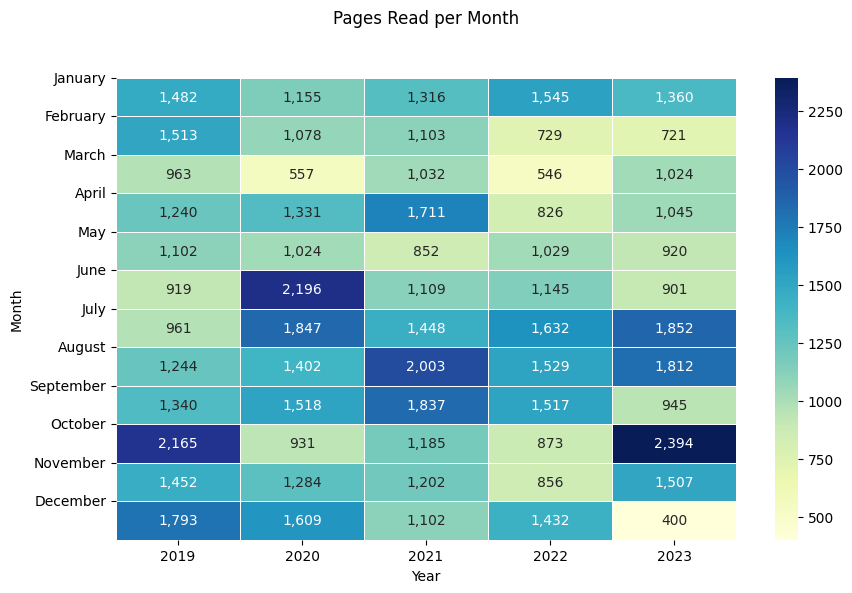

In [14]:
 df = pd.DataFrame(avg_pages_per_month, columns=['Month_Year', 'Pages'])

# Extract month and year from 'Month_Year'
df['Month'] = df['Month_Year'].apply(lambda x: x[0])
df['Year'] = df['Month_Year'].apply(lambda x: x[1])

# Pivot the DataFrame to create a matrix suitable for heatmap
heatmap_data = df.pivot_table(index='Month', columns='Year', values='Pages', aggfunc='sum')

# Plotting heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=',.0f', linewidths=0.7)

plt.yticks(rotation=0)  # Rotate dates for better readability
plt.yticks(ticks=range(len(heatmap_data.index)), va='center', labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
# Add labels and title
plt.title('Pages Read per Month',y=1.1)


# Show the plot
plt.show()

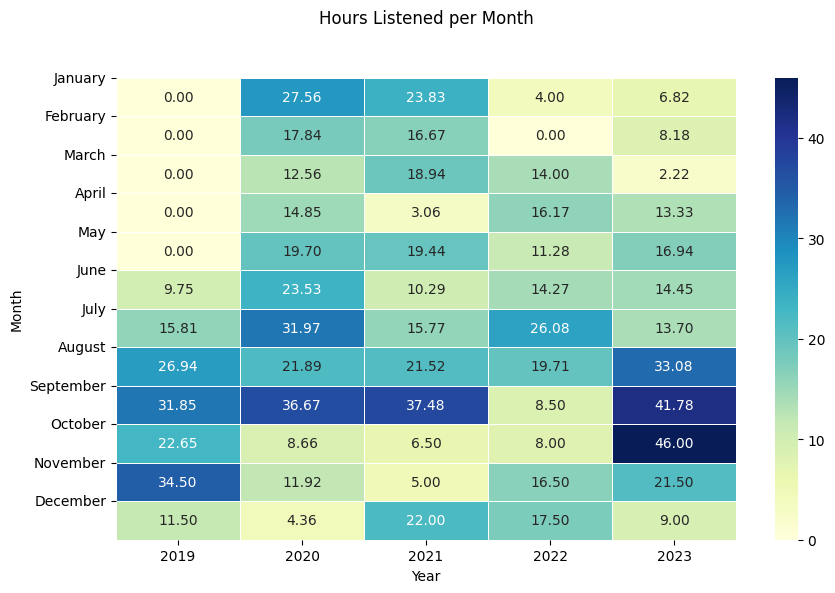

In [15]:
df = pd.DataFrame(avg_hours_per_month, columns=['Month_Year', 'Hours'])

# Extract month and year from 'Month_Year'
df['Month'] = df['Month_Year'].apply(lambda x: x[0])
df['Year'] = df['Month_Year'].apply(lambda x: x[1])

# Pivot the DataFrame to create a matrix suitable for heatmap
heatmap_data = df.pivot_table(index='Month', columns='Year', values='Hours', aggfunc='sum')

# Plotting heatmap
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=',.2f', linewidths=0.7)

plt.yticks(rotation=0)  # Rotate dates for better readability
plt.yticks(ticks=range(len(heatmap_data.index)), va='center', labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
# Add labels and title
plt.title('Hours Listened per Month',y=1.1)


# Show the plot
plt.show()

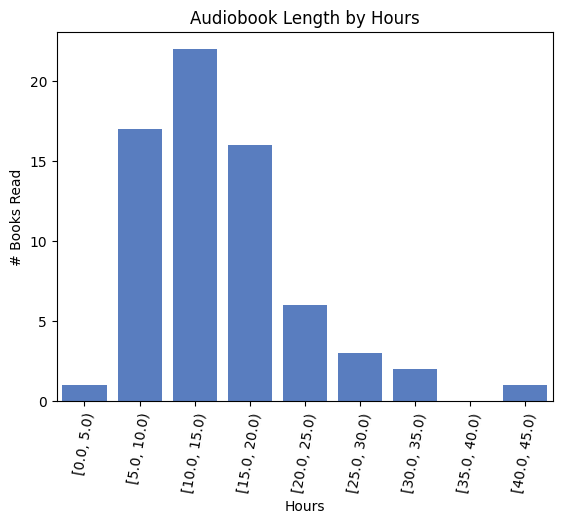

In [16]:
# Book Length - Hours Bins
df = final_df

# Bin the numeric data into intervals of 100
bin_edges = np.arange(0, df['Hours'].max() + 5, 5)  # Adjust the max edge as necessary
df['Binned'] = pd.cut(df['Hours'], bins=bin_edges, right=False)  # right=False makes it [0, 100), [100, 200), etc.

sns.countplot(x='Binned', data=df)
plt.xticks(rotation=80)  # Rotate labels for better readability
plt.title('Audiobook Length by Hours')
plt.xlabel('Hours')
plt.ylabel('# Books Read')
plt.show()

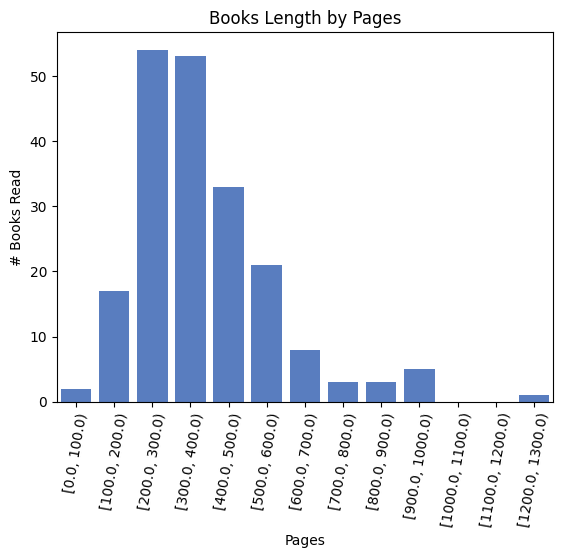

In [17]:
# Book Length - Pages Bins
df = final_df

# Bin the numeric data into intervals of 100
bin_edges = np.arange(0, df['Pages'].max() + 100, 100)  # Adjust the max edge as necessary
df['Binned'] = pd.cut(df['Pages'], bins=bin_edges, right=False)  # right=False makes it [0, 100), [100, 200), etc.

sns.countplot(x='Binned', data=df)
plt.xticks(rotation=80)  # Rotate labels for better readability
plt.title('Books Length by Pages')
plt.xlabel('Pages')
plt.ylabel('# Books Read')
plt.show()

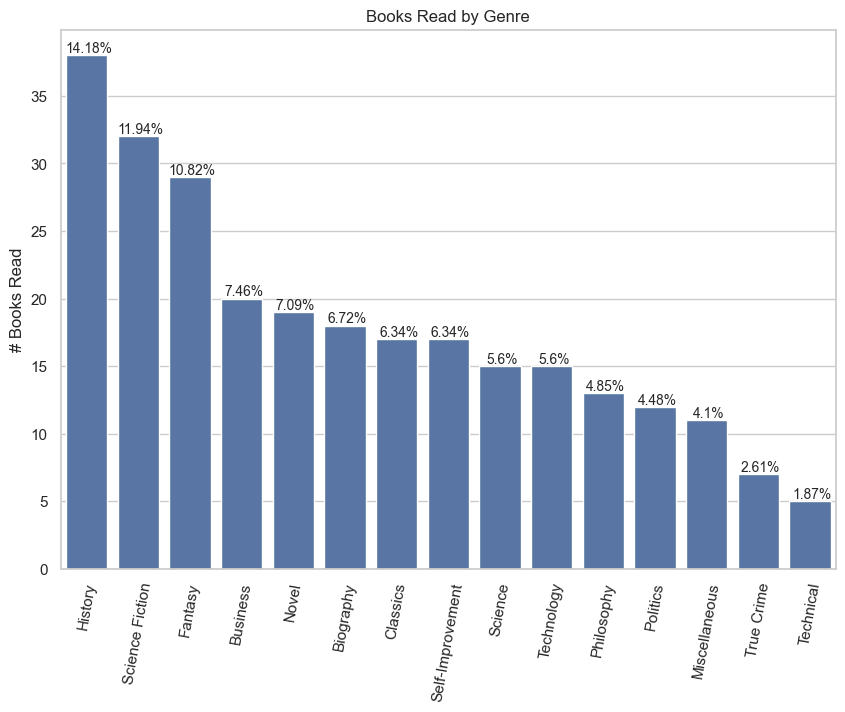

In [18]:
# Genre Distribution

# Calculate the counts and percentages
counts = final_df['Display Genre'].value_counts()
total = counts.sum()
percentages = (counts / total * 100).round(2)

# Creating a count plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 7))
ax = sns.countplot(x='Display Genre', data=final_df, order=counts.index)

# Annotate with the percentage of each category
for p, label in zip(ax.patches, percentages):
    ax.text(p.get_x() + p.get_width() / 1.8, p.get_height() + 0.2, f'{label}%', ha="center", fontsize=10)

plt.title('Books Read by Genre')
plt.xlabel('')
plt.ylabel('# Books Read')
plt.xticks(rotation=80)  # Rotate x-axis labels to 45 degrees

ax = plt.gca()

# Move x-axis labels slightly up
for label in ax.get_xticklabels():
    label.set_position((label.get_position()[0], label.get_position()[1] + 0.0015))  # Adjust the second value as needed

plt.show()

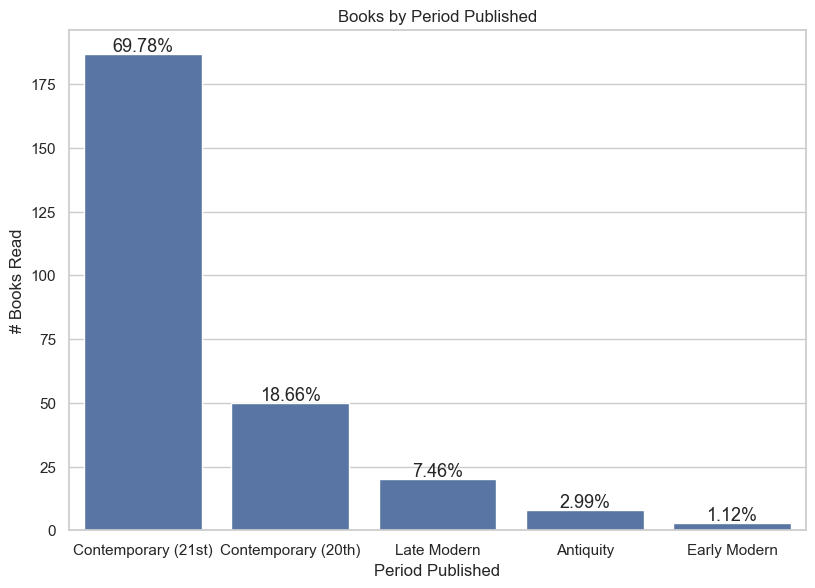

In [19]:
# Calculate the counts and percentages
counts = final_df['Period Published'].value_counts()
total = counts.sum()
percentages = (counts / total * 100).round(2)

# Creating a count plot
sns.set(style="whitegrid")
plt.figure(figsize=(9.5, 6.5))
ax = sns.countplot(x='Period Published', data=final_df, order=counts.index)

# Annotate with the percentage of each category
for p, label in zip(ax.patches, percentages):
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 1, f'{label}%', ha="center", fontsize=13)

plt.title('Books by Period Published')
plt.xlabel('Period Published')
plt.ylabel('# Books Read')
plt.show()


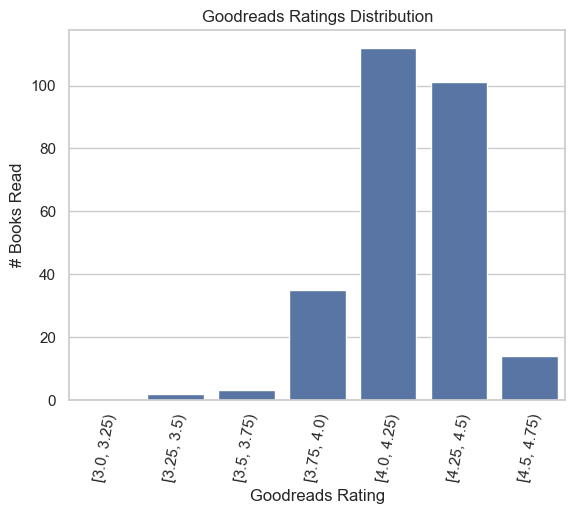

In [20]:
# Book Length - Hours Bins
df = final_df

# Bin the numeric data into intervals of 100
bin_edges = np.arange(3.0, 5, .25)  # Adjust the max edge as necessary
df['Binned'] = pd.cut(df['Goodreads Rating'], bins=bin_edges, right=False)  # right=False makes it [0, 100), [100, 200), etc.

sns.countplot(x='Binned', data=df)
plt.xticks(rotation=80)  # Rotate labels for better readability
plt.title('Goodreads Ratings Distribution')
plt.xlabel('Goodreads Rating')
plt.ylabel('# Books Read')
plt.show()

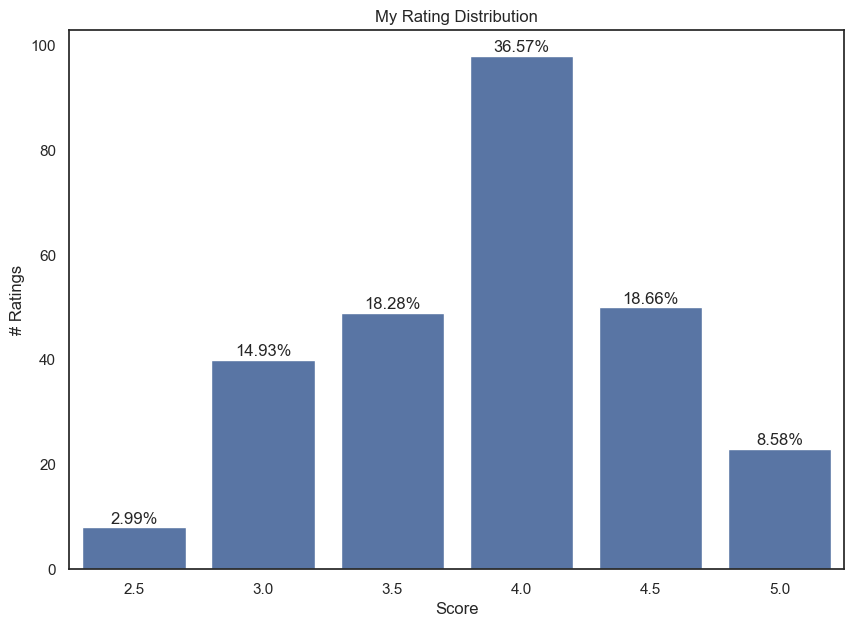

In [21]:
# Calculate the counts and percentages
order = sorted(final_df['My Rating'].unique().tolist())
counts = final_df['My Rating'].value_counts().reindex(order)
total = counts.sum()
percentages = (counts / total * 100).round(2)

# Creating a count plot
sns.set(style="white")
plt.figure(figsize=(10, 7))
ax = sns.countplot(x='My Rating', data=final_df, order=order)

# Annotate with the percentage of each category
for p, label in zip(ax.patches, percentages):
    ax.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.7, f'{label}%', ha="center", fontsize=12)

plt.title('My Rating Distribution')
plt.xlabel('Score')
plt.ylabel('# Ratings')
plt.show()


Text(2.2, 1299.7043233082707, 'Average: 1,276')

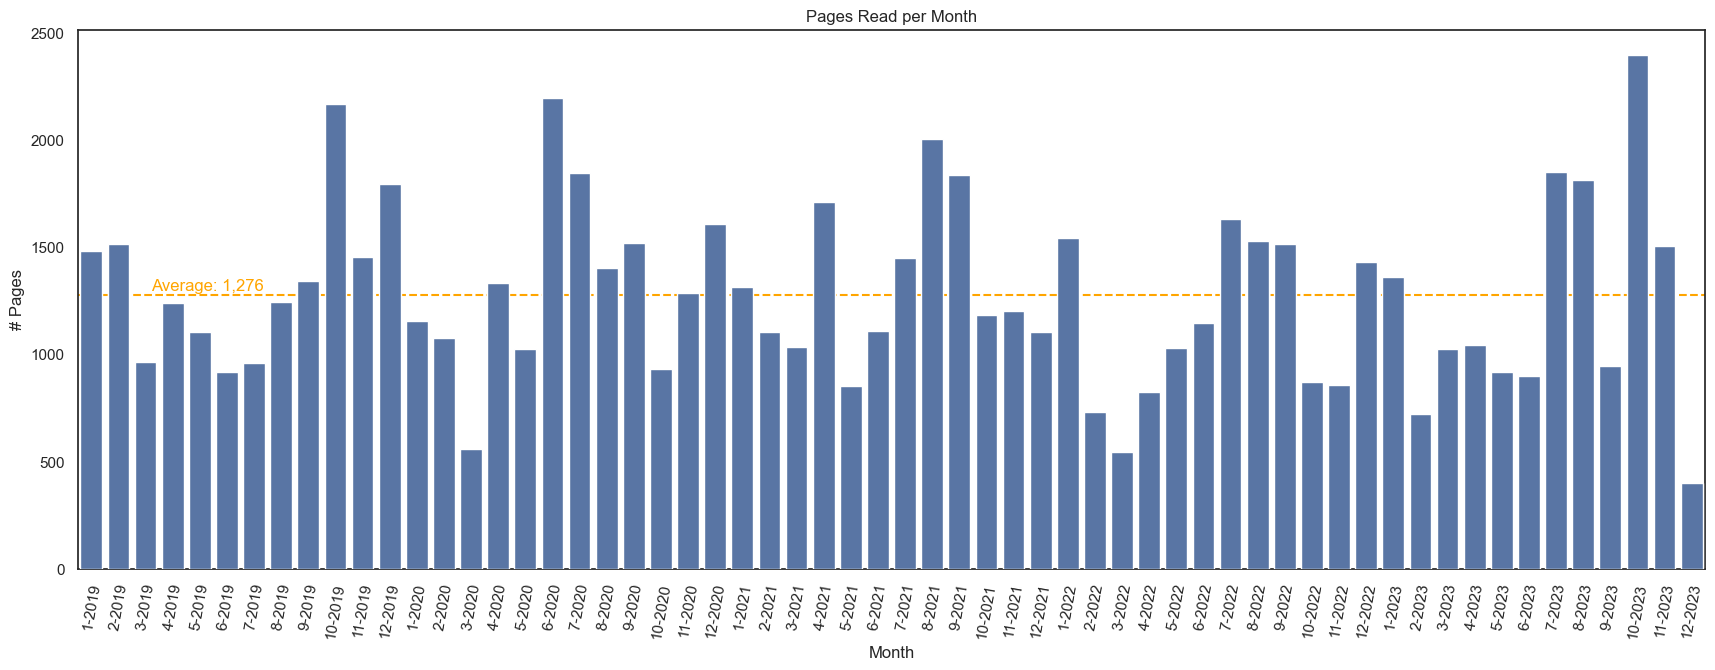

In [22]:
# Convert the list of data into a DataFrame
pages_by_month_df = pd.DataFrame(avg_pages_per_month, columns=['Month', 'Pages'])
pages_by_month_df['Month'] = pages_by_month_df['Month'].apply(lambda x: f"{x[0]}-{x[1]}")

# Split the 'Date' tuple into two separate columns for 'Month' and 'Year'

plt.figure(figsize=(21, 7))
plt.xticks(rotation=80)  # Rotate x-axis labels to 45 degrees

# # Now, you can plot using Seaborn. Let's say we want to plot the 'Value' for each 'Month' in 2019
sns.barplot(x='Month', y='Pages', data=pages_by_month_df, dodge=False, zorder=3)

pages_per_month_mean = pages_by_month_df['Pages'].mean()
plt.axhline(y=pages_per_month_mean, color='orange', linestyle='--', label=f'Average: {pages_per_month_mean:.2f}', zorder=1)

plt.title('Pages Read per Month')
plt.ylabel('# Pages')


offset = max(pages_by_month_df['Pages']) * 0.01  # Calculate an offset as a small percentage of the max value
plt.text(x= 2.2,  # Position the text towards the left of the plot
         y=pages_per_month_mean + offset,  # Just above the line
         s=f'Average: {pages_per_month_mean:,.0f}',  # Text to display
         color='orange')  # Same color as the line for consistency


Text(0.5, 1.0, 'Hours Listened per Month')

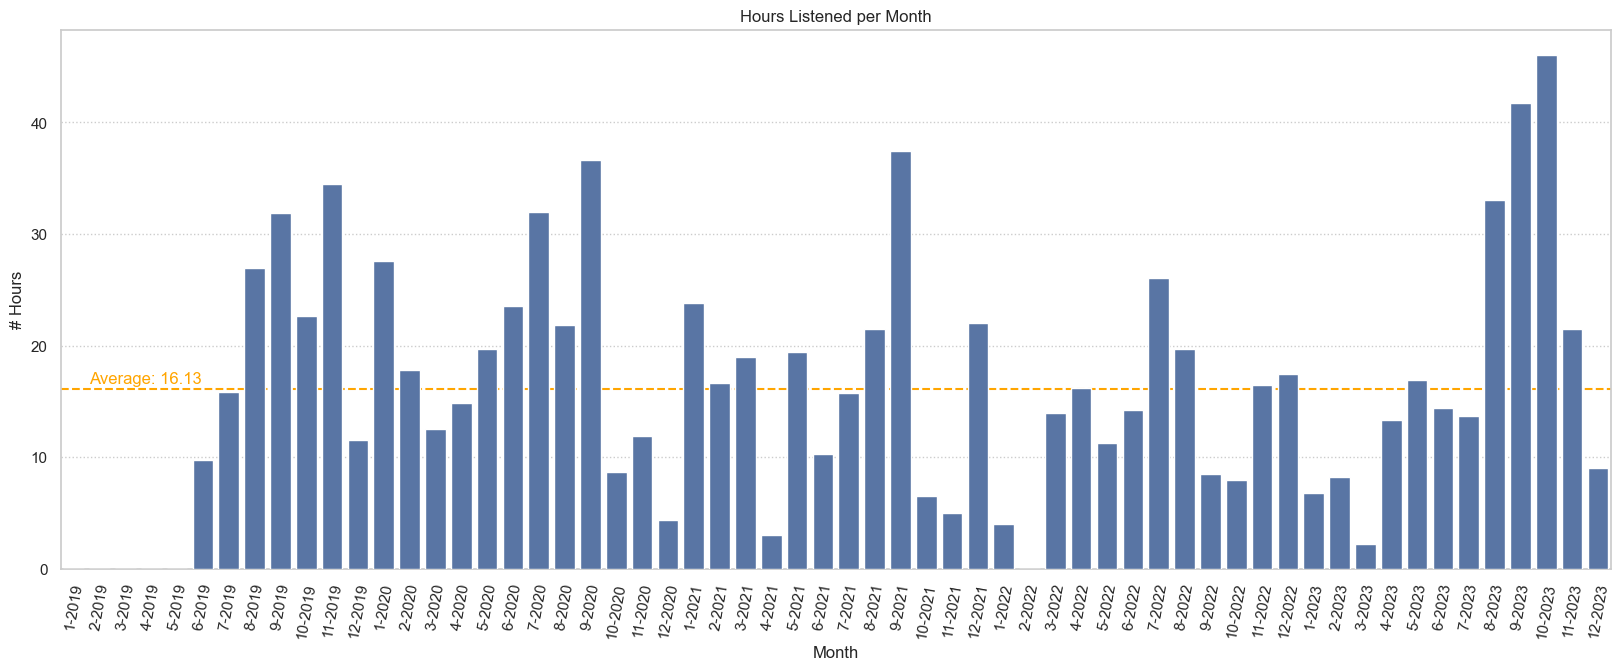

In [32]:
# Convert the list of data into a DataFrame
hours_by_month_df = pd.DataFrame(avg_hours_per_month, columns=['Month', 'Hours'])
hours_by_month_df['Month'] = hours_by_month_df['Month'].apply(lambda x: f"{x[0]}-{x[1]}")

# Split the 'Date' tuple into two separate columns for 'Month' and 'Year'

plt.figure(figsize=(20, 7))
plt.xticks(rotation=80)  # Rotate x-axis labels to 45 degrees

# # Now, you can plot using Seaborn. Let's say we want to plot the 'Value' for each 'Month' in 2019
sns.barplot(x='Month', y='Hours', data=hours_by_month_df, dodge=False,zorder=3)

hours_per_month_mean = hours_by_month_df['Hours'].mean()
plt.axhline(y=hours_per_month_mean, color='orange', linestyle='--', label=f'Average: {hours_per_month_mean:.2f}', zorder=1)
ax.text(200 + 200, 400 + 0.2, f'{hours_per_month_mean}%', ha="center", fontsize=50)

offset = max(hours_by_month_df['Hours']) * 0.01  # Calculate an offset as a small percentage of the max value
plt.text(x= 0.6,  # Position the text towards the left of the plot
         y=hours_per_month_mean + offset,  # Just above the line
         s=f'Average: {hours_per_month_mean:,.2f}',  # Text to display
         color='orange')  # Same color as the line for consistency
plt.ylabel('# Hours')
plt.title('Hours Listened per Month')


In [ ]:
# Creating the scatter plot
sns.color_palette("mako", as_cmap=True)

sns.scatterplot(x='Pages', y='Goodreads Rating', hue='Type', data=final_df, zorder=3, palette="mako")

plt.title('Average Rating vs. Page Length')
plt.xlabel('# Pages')
plt.ylabel('Rating')
sns.set(style="white")

average_value = final_df['Goodreads Rating'].mean().round(1)
plt.legend(loc='lower right', title='Type')

plt.axhline(y=average_value, color='orange', linestyle='--', linewidth=1, label=f'Average: {average_value:.2f}', zorder=1)
ax.text(200 + 200, 400 + 0.2, f'{average_value}%', ha="center", fontsize=50)
plt.text(x= 0.6,  # Position the text towards the left of the plot
         y=average_value + 0.02,  # Just above the line
         s=f'Average',  # Text to display
         color='orange', fontsize=8)  # Same color as the line for consistency


plt.show()

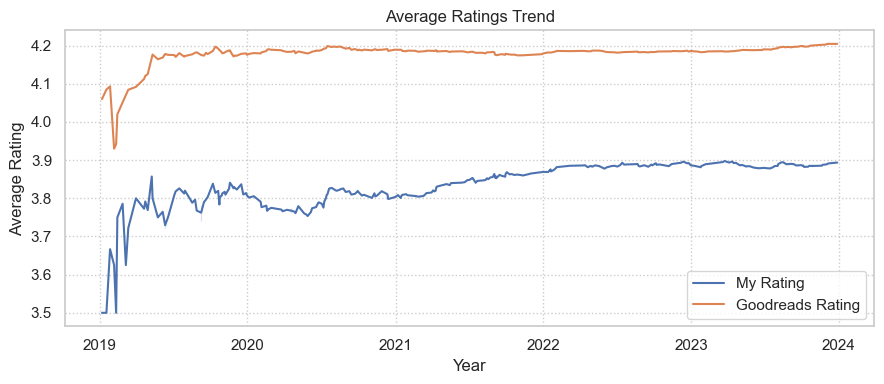

In [29]:
expanding_ratings_df = final_df.sort_values(by='End Date')

# Set the time column as the index
expanding_ratings_df.set_index('End Date', inplace=True)

# Compute the expanding window average
expanding_ratings_df['My Rating Expanding'] = expanding_ratings_df['My Rating'].expanding().mean()
expanding_ratings_df['Goodreads Rating Expanding'] = expanding_ratings_df['Goodreads Rating'].expanding().mean()

plt.figure(figsize=(9, 4))
sns.set_style("whitegrid", {'grid.linestyle': ':'})

sns.lineplot(x='End Date', y='My Rating Expanding', data=expanding_ratings_df, label='My Rating')
sns.lineplot(x='End Date', y='Goodreads Rating Expanding', data=expanding_ratings_df, label='Goodreads Rating')
plt.legend()

plt.title('Average Ratings Trend')
plt.ylabel('Average Rating')
plt.xlabel('Year')
plt.xticks(rotation=0)  # Rotate dates for better readability
plt.tight_layout()  # Adjust layout
plt.show()

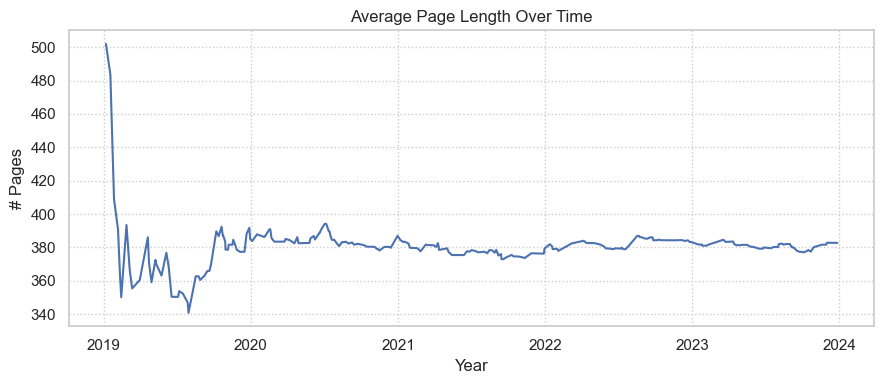

In [30]:
expanding_pages_df = final_df.sort_values(by='End Date')

# Set the time column as the index
expanding_pages_df.set_index('End Date', inplace=True)

# Compute the expanding window average
expanding_pages_df['Pages Expanding'] = expanding_pages_df['Pages'].expanding().mean()

plt.figure(figsize=(9, 4))

sns.lineplot(x='End Date', y='Pages Expanding', data=expanding_pages_df, zorder=3)

# TODO - add point on current average at end of line
plt.title('Average Page Length Over Time')
plt.xlabel('Year')
plt.ylabel('# Pages')
#plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()  # Adjust layout
plt.show()

In [ ]:
# Read On Release = true if read within ~1 year of release
non_fiction_df = final_df[final_df['My Rating']==5.0]
non_fiction_df['Ten Years Old?'] = non_fiction_df.apply(lambda row: True if (row['Year Read'] - row['Year Published']) >= 9 else False, axis=1)
ten_years_old = non_fiction_df[non_fiction_df['Ten Years Old?']==True]
#ten_years_old.mean()
ten_years_old

In [27]:
fiction_df = final_df[final_df['Type'] == 'Fiction']
non_fiction_df = final_df[final_df['Type'] == 'Non-Fiction']

my_rating_fiction = fiction_df['My Rating'].mean()
gr_rating_fiction = fiction_df['Goodreads Rating'].mean()
rating_delta_fiction = fiction_df['Rating Delta'].mean()

my_rating_nonfiction = non_fiction_df['My Rating'].mean()
gr_rating_nonfiction = non_fiction_df['Goodreads Rating'].mean()
rating_delta_nonfiction = non_fiction_df['Rating Delta'].mean()


print(f"{my_rating_fiction = :.2f}")
print(f"{gr_rating_fiction = :.2f}")
print(f"{rating_delta_fiction = :.2f}")

print(f"{my_rating_nonfiction = :.2f}")
print(f"{gr_rating_nonfiction = :.2f}")
print(f"{rating_delta_nonfiction = :.2f}")

overall_delta = goodreads_rating_average-my_rating_average
delta_diff_type = abs(rating_delta_fiction) - abs(rating_delta_nonfiction)
overall_delta
percentage_diff = (delta_diff_type / overall_delta) * 100

print(f"{-overall_delta = :.2f}")
print(f"{-delta_diff_type = :.2f}")
print(f"{percentage_diff = :.2f}")


my_rating_fiction = 3.82
gr_rating_fiction = 4.20
rating_delta_fiction = -0.38
my_rating_nonfiction = 3.94
gr_rating_nonfiction = 4.21
rating_delta_nonfiction = -0.27
-overall_delta = -0.31
-delta_diff_type = -0.10
percentage_diff = 32.90


In [26]:
male_df = final_df[final_df['Author Gender'] == 'Male']
female_df = final_df[final_df['Author Gender'] == 'Female']

female_nf_df = female_df[female_df['Type']=='Non-Fiction']

my_rating_male_df = male_df['My Rating'].mean()
gr_rating_male_df = male_df['Goodreads Rating'].mean()
rating_delta_male_df = male_df['Rating Delta'].mean()

my_rating_female_df = female_df['My Rating'].mean()
gr_rating_female_df = female_df['Goodreads Rating'].mean()
rating_delta_female_df = female_df['Rating Delta'].mean()


print(f"{my_rating_male_df = :.2f}")
print(f"{gr_rating_male_df = :.2f}")
print(f"{rating_delta_male_df = :.2f}")

print(f"{my_rating_female_df = :.2f}")
print(f"{gr_rating_female_df = :.2f}")
print(f"{rating_delta_female_df = :.2f}")


my_rating_male_df = 3.91
gr_rating_male_df = 4.21
rating_delta_male_df = -0.30
my_rating_female_df = 3.70
gr_rating_female_df = 4.20
rating_delta_female_df = -0.50


In [25]:
data = {'genre': ['Fiction', 'Non-Fiction', 'Fantasy', 'Mystery', 'Science Fiction'],
        'rating': [4.2, 4.0, 4.5, 3.8, 4.1]}
df = pd.DataFrame(data)
avg_ratings = final_df.groupby('Display Genre')['My Rating'].mean().reset_index()
avg_ratings_by_genre_sorted_df = avg_ratings.sort_values(by='My Rating', ascending=False)
avg_ratings_by_genre_sorted_df

/var/folders/sf/9c9rzpyx3433zsvwfyt4fccw0000gn/T/ipykernel_23035/1159170356.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_ratings = final_df.groupby('Display Genre')['My Rating'].mean().reset_index()


,Display Genre,My Rating
14,True Crime,4.500000
1,Business,4.150000
12,Technical,4.100000
4,History,4.039474
13,Technology,4.033333
11,Self-Improvement,4.029412
2,Classics,3.941176
5,Miscellaneous,3.909091
10,Science Fiction,3.828125
6,Novel,3.815789


/var/folders/sf/9c9rzpyx3433zsvwfyt4fccw0000gn/T/ipykernel_23035/565737781.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cumulative_df['cumulative_books_read'] = cumulative_df.groupby('Format').cumcount() + 1
/var/folders/sf/9c9rzpyx3433zsvwfyt4fccw0000gn/T/ipykernel_23035/565737781.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = cumulative_df.pivot_table(index='Start Date', columns='Format', values='cumulative_books_read', aggfunc='last')


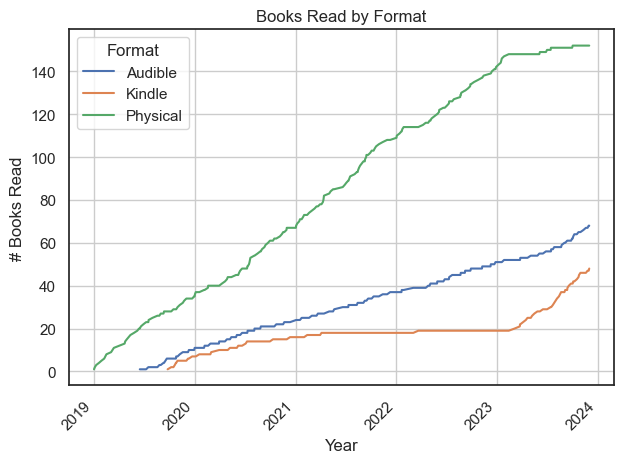

In [24]:
cumulative_df = final_df
# Cumulative count of each category over time
cumulative_df['cumulative_books_read'] = cumulative_df.groupby('Format').cumcount() + 1

# Pivot the DataFrame to have categories as columns and timestamps as index
df_pivot = cumulative_df.pivot_table(index='Start Date', columns='Format', values='cumulative_books_read', aggfunc='last')

# Forward fill to handle timestamps without new data for continuity in the plot
df_pivot = df_pivot.ffill()

# Plotting
df_pivot.plot(kind='line')
plt.title('Books Read by Format')
plt.xlabel('Year')
plt.ylabel('# Books Read')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()